# сии лаб 5

## импорты

In [52]:
! pip install tensorflow

   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/332.0 MB ? eta -:--:--
   ---------------------------------------- 2.6/332.0 MB 9.5 MB/s eta 0:00:35
    --------------------------------------- 5.2/332.0 MB 10.7 MB/s eta 0:00:31
    --------------------------------------- 7.6/332.0 MB 11.1 MB/s eta 0:00:30
   - -------------------------------------- 10.2/332.0 MB 11.3 MB/s eta 0:00:29
   - -------------------------------------- 11.0/332.0 MB 10.1 MB/s eta 0:00:32
   - -------------------------------------- 11.3/332.0 MB 9.0 MB/s eta 0:00:36
   - -------------------------------------- 12.3/332.0 MB 8.0 MB/s eta 0:00:40
   - -------------------------------------- 14.2/332.0 MB 8.1 MB/s eta 0:00:40
   - -------------------------------------- 16.0/332.0 MB 8.2 MB/s eta 0:00:39
   -- ------------------------------------- 17.8/332.0 MB 8.3 MB/s eta 0:00:38
   -- ------------------------------------- 19.7/332.0 MB 8.4 MB/s 

In [53]:
import numpy as np
import pandas as pd

import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt

import PIL.Image as Image
import os
import time
import pickle
import gzip

from tensorflow.keras.datasets import mnist

## всякие классы

### слои (лазаньи)

In [17]:
class Linear(torch.nn.Module):
    def __init__(self, in_features: int, out_features: int, use_bias: bool = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.randn(out_features, in_features) * (2.0 / in_features) ** 0.5)
        self.bias = torch.nn.Parameter(torch.zeros(out_features)) if use_bias else None
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:        
        return torch.matmul(x, self.weight.T) + (self.bias if self.bias is not None else 0)


class Dropout(torch.nn.Module):
    def __init__(self, p: float = 0.5):
        super().__init__()
        if not 0 <= p < 1: raise ValueError(f"ну епаресете {p}")
        self.p = p
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if not self.training or self.p == 0: return x        
        return x * torch.bernoulli(torch.ones_like(x) * (1 - self.p)) * (1.0 / (1.0 - self.p))


class Flatten(torch.nn.Module):
    def __init__(self, start_dim: int = 1):
        super().__init__()
        self.start_dim = start_dim
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_shape = x.shape[:self.start_dim]
        flat_size = 1
        for dim in x.shape[self.start_dim:]:
            flat_size *= dim
        
        return x.reshape(*batch_shape, flat_size)


class Conv2D(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, padding: int = 0, use_bias: bool = True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weight = torch.nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size) * (2.0 / (in_channels * kernel_size * kernel_size)) ** 0.5)
        self.bias = torch.nn.Parameter(torch.zeros(out_channels)) if use_bias else None
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, _, h_in, w_in = x.shape
        
        if self.padding > 0:
            x = torch.nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding))
        
        # вместо форов должно ьыть быстрей
        x_unf = torch.nn.functional.unfold(x, kernel_size=self.kernel_size, stride=self.stride)        
        w = self.weight.view(self.out_channels, -1)
        out = w @ x_unf
        
        if self.bias is not None: out = out + self.bias.view(1, -1, 1)
    
        h_out = (h_in + 2 * self.padding - self.kernel_size) // self.stride + 1
        w_out = (w_in + 2 * self.padding - self.kernel_size) // self.stride + 1
        
        out = out.view(batch_size, self.out_channels, h_out, w_out)
        
        return out


class MaxPool2D(torch.nn.Module):
    def __init__(self, kernel_size: int = 2, stride: int = 1):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, channels, h_in, w_in = x.shape
        
        # опять анфолд
        x_unf = torch.nn.functional.unfold(x, kernel_size=self.kernel_size, stride=self.stride)
        h_out = (h_in - self.kernel_size) // self.stride + 1
        w_out = (w_in - self.kernel_size) // self.stride + 1
        
        x_unf = x_unf.view(batch_size, channels, self.kernel_size * self.kernel_size, -1)
        out, _ = torch.max(x_unf, dim=2)
        
        out = out.view(batch_size, channels, h_out, w_out)
        
        return out

### активации (виндоус)

In [9]:
def relu(x: torch.Tensor) -> torch.Tensor:
    # RELU(x) = max(0, x)
    return torch.maximum(x, torch.zeros_like(x))


def softmax(x: torch.Tensor, dim: int = -1) -> torch.Tensor:
    # Softmax(x_i) = exp(x_i) / sum(exp(x_j))
    exp_x = torch.exp(x - torch.max(x, dim=dim, keepdim=True).values)
    return exp_x / torch.sum(exp_x, dim=dim, keepdim=True)

### оптимизаторы

In [8]:
class SGD:
    def __init__(self, parameters: list, lr: float = 0.01, momentum: float = 0.0):
        self.parameters = parameters
        self.lr = lr
        self.momentum = momentum
        self.velocities = [torch.zeros_like(p) for p in parameters] if momentum > 0 else None
    
    def zero_grad(self):
        for p in self.parameters:
            if p.grad is not None: p.grad.zero_()
    
    def step(self):
        for i, p in enumerate(self.parameters):
            if p.grad is None: continue
            
            if self.velocities is not None:
                self.velocities[i] = self.momentum * self.velocities[i] - self.lr * p.grad
                p.data += self.velocities[i]
            else:
                p.data -= self.lr * p.grad


class Adam:
    def __init__(self, parameters: list, lr: float = 0.001, betas: tuple = (0.9, 0.999), eps: float = 1e-8):
        self.parameters = parameters
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.m = [torch.zeros_like(p) for p in parameters]
        self.v = [torch.zeros_like(p) for p in parameters]
        self.t = 0
    
    def zero_grad(self):
        for p in self.parameters:
            if p.grad is not None: p.grad.zero_()
    
    def step(self):
        self.t += 1
        
        for i, p in enumerate(self.parameters):
            if p.grad is None: continue
            grad = p.grad
            
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)
            
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            
            p.data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

### модель из всего этого

In [64]:
def cross_entropy_loss(predictions, targets):
    return torch.nn.functional.cross_entropy(predictions, targets)


class CustomModel(torch.nn.Module):
    def __init__(self, conv_blocks=1, line_blocks=1, num_classes=10, input_size=28):
        super().__init__()
        self.conv_blocks_count = conv_blocks
        self.line_blocks_count = line_blocks
        self.num_classes = num_classes
        self.input_size = input_size
        
        self.conv_layers = torch.nn.ModuleList()
        self.pool_layers = torch.nn.ModuleList()
        self.fc_layers = torch.nn.ModuleList()
        self.dropout_layers = torch.nn.ModuleList()
        
        # conv блок = Conv2D + ReLU + MaxPool2D
        for i in range(conv_blocks):
            in_ch = 1 if i == 0 else 64  # MNIST имеет 1 канал
            self.conv_layers.append(Conv2D(in_ch, 64, kernel_size=3, padding=1))
            self.pool_layers.append(MaxPool2D(kernel_size=2, stride=2))
        
        self.flatten = Flatten()
        
        # Рассчитываем размер после convolution and pooling
        # Каждый pooling делит размер на 2
        feature_size = input_size // (2 ** conv_blocks)
        flat_size = 64 * feature_size * feature_size
        
        # line блок = Linear + ReLU + Dropout
        for i in range(line_blocks):
            in_feat = flat_size if i == 0 else 256
            self.fc_layers.append(Linear(in_feat, 256))
            self.dropout_layers.append(Dropout(p=0.5))
        
        # out
        last_feat = 256 if line_blocks > 0 else flat_size
        self.output_layer = Linear(last_feat, num_classes)
        
        self.optimizer = None

    def forward(self, x):
        for i in range(self.conv_blocks_count):
            x = self.pool_layers[i](relu(self.conv_layers[i](x)))
        
        x = self.flatten(x)
        
        for i in range(self.line_blocks_count):
            x = self.dropout_layers[i](relu(self.fc_layers[i](x)))
        
        x = self.output_layer(x)
        return x
    
    def set_optimizer(self, optimizer):
        self.optimizer = optimizer
    
    def fit(self, X_train, y_train, epochs=5, batch_size=64, verbose=True):
        if self.optimizer is None: 
            raise ValueError("без оптимизатора пока нельзя")
        
        if isinstance(X_train, np.ndarray):
            X_train = torch.from_numpy(X_train).float()
            y_train = torch.from_numpy(y_train).long()
        
        device = next(self.parameters()).device
        dataset = torch.utils.data.TensorDataset(X_train, y_train)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        history = {'train_loss': [], 'train_acc': []}
        
        start_time = time.time()
        
        for epoch in range(epochs):
            self.train()
            epoch_loss = 0.0
            correct = 0
            total = 0
            
            for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                # вперед
                predictions = self(X_batch)
                loss = cross_entropy_loss(predictions, y_batch)
                
                # назад
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                # резы
                pred_classes = torch.argmax(predictions, dim=1)
                correct += (pred_classes == y_batch).sum().item()
                total += y_batch.shape[0]
                epoch_loss += loss.item()
                
                if verbose and batch_idx % 100 == 0:
                    print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}")
            
            # резы эпохи
            avg_loss = epoch_loss / len(dataloader)
            accuracy = 100.0 * correct / total
            history['train_loss'].append(avg_loss)
            history['train_acc'].append(accuracy)
            
            if verbose:
                print(f"завершилась эпоха {epoch+1}/{epochs}: лоссс={avg_loss:.4f}, точность={accuracy:.2f}%")
        
        end_time = time.time()
        if verbose:
            print(f"\n===== обучились за {end_time - start_time:.2f} секунд =====")
        
        return history
    
    def evaluate(self, X, y, batch_size=64):
        self.eval()
        device = next(self.parameters()).device
        
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X).float()
            y = torch.from_numpy(y).long()
        
        dataset = torch.utils.data.TensorDataset(X, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
        with torch.no_grad():
            total_loss = 0.0
            correct = 0
            total = 0
            
            for X_batch, y_batch in dataloader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                predictions = self(X_batch)
                loss = cross_entropy_loss(predictions, y_batch)
                
                pred_classes = torch.argmax(predictions, dim=1)
                correct += (pred_classes == y_batch).sum().item()
                total += y_batch.shape[0]
                total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        accuracy = 100.0 * correct / total
        
        return avg_loss, accuracy

## загрузка датасета и предобработка

In [ ]:
print("загрузка датасета...")
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# нормализация
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

# канал (N, 28, 28) -> (N, 1, 28, 28)
X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

# переход в тензоры
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

print(f"Тренировочная выборка: {X_train.shape}, {y_train.shape}")
print(f"Тестовая выборка: {X_test.shape}, {y_test.shape}")
print(f"Классы (цифры): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9")

загрузка датасета...
Тренировочная выборка: (60000, 1, 28, 28), (60000,)
Тестовая выборка: (10000, 1, 28, 28), (10000,)
Классы (цифры): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
Тренировочная выборка: (60000, 1, 28, 28), (60000,)
Тестовая выборка: (10000, 1, 28, 28), (10000,)
Классы (цифры): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9


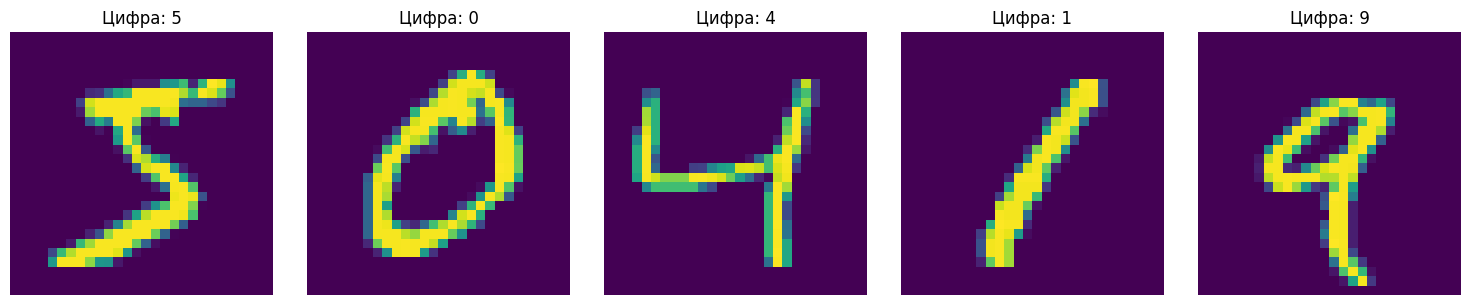

In [67]:
# первые 5 картинок из датасета
plt.figure(figsize=(15, 3))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = X_train[i].transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Цифра: {y_train[i]}')

plt.tight_layout()
plt.show()

## обучение моделей

In [68]:
# CUDA
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используемое устройство: {device}\n")

# МОДЕЛЬ 1: шляпная (1 conv, 1 fc)
print("=" * 60)
print("МОДЕЛЬ 1")
print("=" * 60)
model1 = CustomModel(conv_blocks=1, line_blocks=1, num_classes=10, input_size=28).to(device)
model1.set_optimizer(Adam(list(model1.parameters()), lr=0.001))
history1 = model1.fit(X_train_tensor, y_train_tensor, epochs=5, batch_size=64, verbose=True)

# МОДЕЛЬ 2: допустимая (2 conv, 2 fc)
print("\n" + "=" * 60)
print("МОДЕЛЬ 2")
print("=" * 60)
model2 = CustomModel(conv_blocks=2, line_blocks=2, num_classes=10, input_size=28).to(device)
model2.set_optimizer(Adam(list(model2.parameters()), lr=0.001))
history2 = model2.fit(X_train_tensor, y_train_tensor, epochs=5, batch_size=64, verbose=True)

# МОДЕЛЬ 3: здравая (3 conv, 1 fc, SGD)
print("\n" + "=" * 60)
print("МОДЕЛЬ 3")
print("=" * 60)
model3 = CustomModel(conv_blocks=3, line_blocks=1, num_classes=10, input_size=28).to(device)
model3.set_optimizer(SGD(list(model3.parameters()), lr=0.01, momentum=0.9))
history3 = model3.fit(X_train_tensor, y_train_tensor, epochs=5, batch_size=64, verbose=True)

# итог на трэйне
print("\n" + "=" * 60)
print("итог на тренировочной выборке")
print("=" * 60)
print(f"модель 1 (1 conv, 1 fc): Acc={history1['train_acc'][-1]:.2f}%")
print(f"модель 2 (2 conv, 2 fc): Acc={history2['train_acc'][-1]:.2f}%")
print(f"модель 3 (3 conv, 1 fc): Acc={history3['train_acc'][-1]:.2f}%")

# тестовая выборка
print("\n" + "=" * 60)
print("резудьтаты на тестовой выборке")
print("=" * 60)
test_loss1, test_acc1 = model1.evaluate(X_test_tensor, y_test_tensor)
test_loss2, test_acc2 = model2.evaluate(X_test_tensor, y_test_tensor)
test_loss3, test_acc3 = model3.evaluate(X_test_tensor, y_test_tensor)

print(f"модель 1: Test Loss={test_loss1:.4f}, Test Acc={test_acc1:.2f}%")
print(f"модель 2: Test Loss={test_loss2:.4f}, Test Acc={test_acc2:.2f}%")
print(f"модель 3: Test Loss={test_loss3:.4f}, Test Acc={test_acc3:.2f}%")

Используемое устройство: cpu

МОДЕЛЬ 1
Epoch 1/5, Batch 0/938, Loss: 2.6067
Epoch 1/5, Batch 100/938, Loss: 0.2989
Epoch 1/5, Batch 100/938, Loss: 0.2989
Epoch 1/5, Batch 200/938, Loss: 0.2813
Epoch 1/5, Batch 200/938, Loss: 0.2813
Epoch 1/5, Batch 300/938, Loss: 0.1412
Epoch 1/5, Batch 300/938, Loss: 0.1412
Epoch 1/5, Batch 400/938, Loss: 0.1494
Epoch 1/5, Batch 400/938, Loss: 0.1494
Epoch 1/5, Batch 500/938, Loss: 0.3645
Epoch 1/5, Batch 500/938, Loss: 0.3645
Epoch 1/5, Batch 600/938, Loss: 0.1978
Epoch 1/5, Batch 600/938, Loss: 0.1978
Epoch 1/5, Batch 700/938, Loss: 0.2357
Epoch 1/5, Batch 700/938, Loss: 0.2357
Epoch 1/5, Batch 800/938, Loss: 0.0945
Epoch 1/5, Batch 800/938, Loss: 0.0945
Epoch 1/5, Batch 900/938, Loss: 0.1036
Epoch 1/5, Batch 900/938, Loss: 0.1036
завершилась эпоха 1/5: лоссс=0.2365, точность=92.75%
Epoch 2/5, Batch 0/938, Loss: 0.0346
завершилась эпоха 1/5: лоссс=0.2365, точность=92.75%
Epoch 2/5, Batch 0/938, Loss: 0.0346
Epoch 2/5, Batch 100/938, Loss: 0.0898
Epo

## графики и все такое

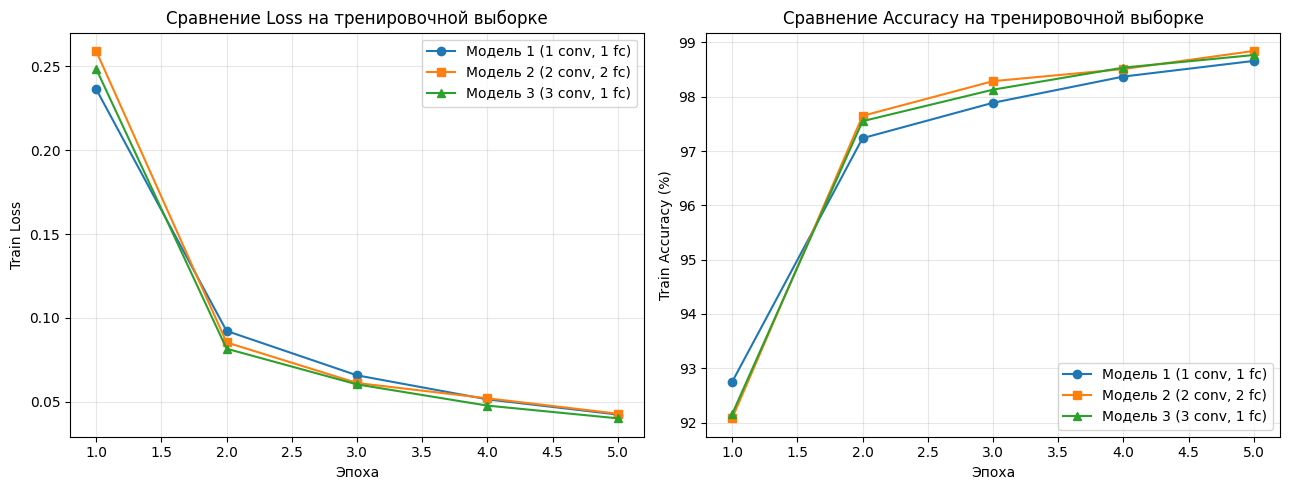

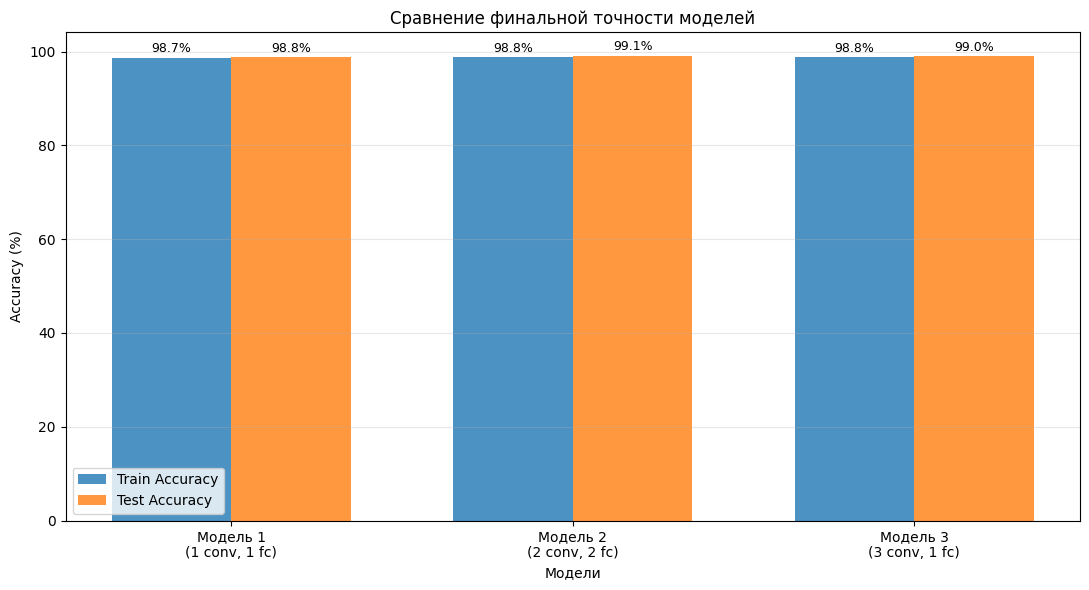

In [69]:
# loss
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(history1['train_loss']) + 1), history1['train_loss'], marker='o', label='Модель 1 (1 conv, 1 fc)')
plt.plot(range(1, len(history2['train_loss']) + 1), history2['train_loss'], marker='s', label='Модель 2 (2 conv, 2 fc)')
plt.plot(range(1, len(history3['train_loss']) + 1), history3['train_loss'], marker='^', label='Модель 3 (3 conv, 1 fc)')
plt.xlabel('Эпоха')
plt.ylabel('Train Loss')
plt.title('Сравнение Loss на тренировочной выборке')
plt.legend()
plt.grid(True, alpha=0.3)

# accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(history1['train_acc']) + 1), history1['train_acc'], marker='o', label='Модель 1 (1 conv, 1 fc)')
plt.plot(range(1, len(history2['train_acc']) + 1), history2['train_acc'], marker='s', label='Модель 2 (2 conv, 2 fc)')
plt.plot(range(1, len(history3['train_acc']) + 1), history3['train_acc'], marker='^', label='Модель 3 (3 conv, 1 fc)')
plt.xlabel('Эпоха')
plt.ylabel('Train Accuracy (%)')
plt.title('Сравнение Accuracy на тренировочной выборке')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# тестовая выборка
plt.figure(figsize=(11, 6))
models = ['Модель 1\n(1 conv, 1 fc)', 'Модель 2\n(2 conv, 2 fc)', 'Модель 3\n(3 conv, 1 fc)']
test_accuracies = [test_acc1, test_acc2, test_acc3]
train_accuracies = [history1['train_acc'][-1], history2['train_acc'][-1], history3['train_acc'][-1]]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, train_accuracies, width, label='Train Accuracy', alpha=0.8)
plt.bar(x + width/2, test_accuracies, width, label='Test Accuracy', alpha=0.8)

plt.xlabel('Модели')
plt.ylabel('Accuracy (%)')
plt.title('Сравнение финальной точности моделей')
plt.xticks(x, models)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

for i, (train, test) in enumerate(zip(train_accuracies, test_accuracies)):
    plt.text(i - width/2, train + 0.5, f'{train:.1f}%', ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, test + 0.5, f'{test:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### ROC_AUC

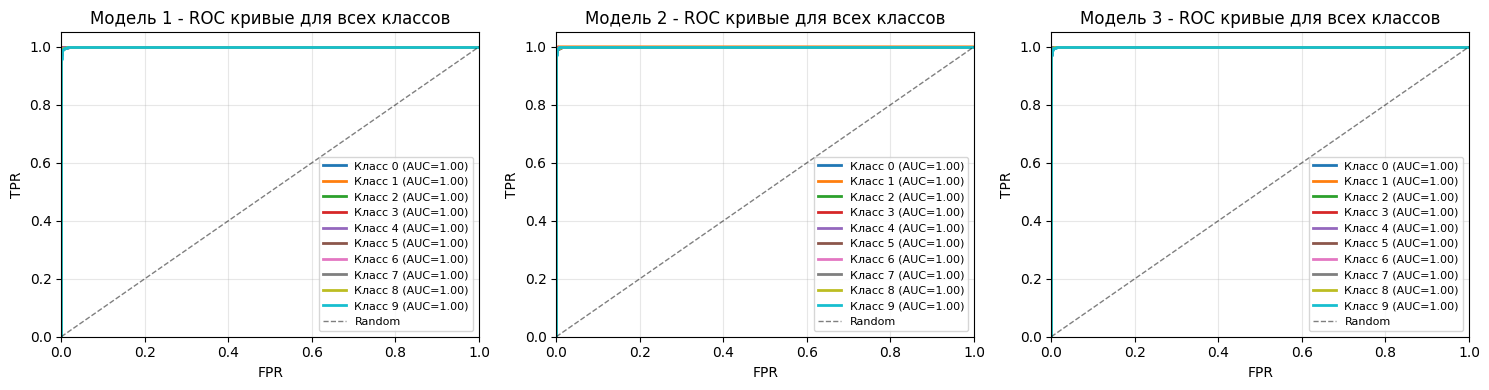

In [70]:
def compute_roc_auc(model, X, y, device):
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        dataset = torch.utils.data.TensorDataset(X, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
        
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            pred = model(X_batch)
            prob = torch.nn.functional.softmax(pred, dim=1)
            all_probs.append(prob.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
    
    all_probs = np.vstack(all_probs)
    all_labels = np.hstack(all_labels)
    
    return all_probs, all_labels

# вероятности
probs1, labels1 = compute_roc_auc(model1, X_test_tensor, y_test_tensor, device)
probs2, labels2 = compute_roc_auc(model2, X_test_tensor, y_test_tensor, device)
probs3, labels3 = compute_roc_auc(model3, X_test_tensor, y_test_tensor, device)

# отмена небинарности
labels1_bin = label_binarize(labels1, classes=range(10))
labels2_bin = label_binarize(labels2, classes=range(10))
labels3_bin = label_binarize(labels3, classes=range(10))

# ROC
colors = plt.cm.tab10(np.linspace(0, 1, 10))

plt.figure(figsize=(15, 4))

models_list = [(probs1, labels1_bin, 'Модель 1'), (probs2, labels2_bin, 'Модель 2'), (probs3, labels3_bin, 'Модель 3')]

for model_idx, (probs, labels_bin, model_name) in enumerate(models_list):
    plt.subplot(1, 3, model_idx + 1)
    
    for class_idx in range(10):
        fpr, tpr, _ = roc_curve(labels_bin[:, class_idx], probs[:, class_idx])
        roc_auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[class_idx], lw=2, label=f'Класс {class_idx} (AUC={roc_auc_score:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5, label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'{model_name} - ROC кривые для всех классов')
    plt.legend(loc='lower right', fontsize=8)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## кастомная картинка

картинка из ./images/super_test.png загружена


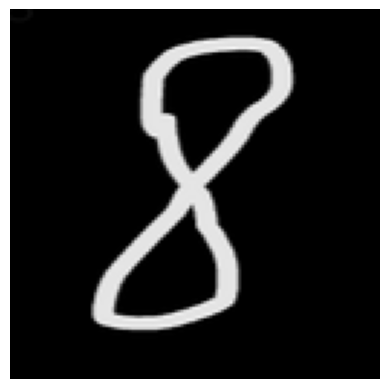

In [76]:
def get_image(image_path: str, size: int) -> None | np.ndarray:
    """загружает, ресайзит и инвертирует картинку"""
    if not os.path.exists(image_path):
        print(f"картинка в {image_path} не найдена")
        return None
    
    print(f"картинка из {image_path} загружена")
    return 255 - np.asarray(Image.open(image_path).convert('RGBA').resize((size, size), Image.Resampling.LANCZOS), dtype=np.uint8)[..., :3]

def show_image(image: np.ndarray) -> None:
    plt.imshow(image)
    plt.axis('off')
    plt.show()

IMAGE_PATH = './images/super_test.png'
custom_image = get_image(IMAGE_PATH, size=128)
if custom_image is not None: show_image(custom_image)


предсказание 1

Модель 1 (1 conv, 1 fc):
  предсказание: 8
  уверенность: 98.92%
  вероятности:
    Класс 0:   0.00%
    Класс 1:   0.09%
    Класс 2:   0.00%
    Класс 3:   0.02%
    Класс 4:   0.00%
    Класс 5:   0.91%
    Класс 6:   0.05%
    Класс 7:   0.00%
    Класс 8:  98.92%
    Класс 9:   0.00%

Модель 2 (2 conv, 2 fc):
  предсказание: 8
  уверенность: 100.00%
  вероятности:
    Класс 0:   0.00%
    Класс 1:   0.00%
    Класс 2:   0.00%
    Класс 3:   0.00%
    Класс 4:   0.00%
    Класс 5:   0.00%
    Класс 6:   0.00%
    Класс 7:   0.00%
    Класс 8: 100.00%
    Класс 9:   0.00%

Модель 3 (3 conv, 1 fc):
  предсказание: 8
  уверенность: 100.00%
  вероятности:
    Класс 0:   0.00%
    Класс 1:   0.00%
    Класс 2:   0.00%
    Класс 3:   0.00%
    Класс 4:   0.00%
    Класс 5:   0.00%
    Класс 6:   0.00%
    Класс 7:   0.00%
    Класс 8: 100.00%
    Класс 9:   0.00%


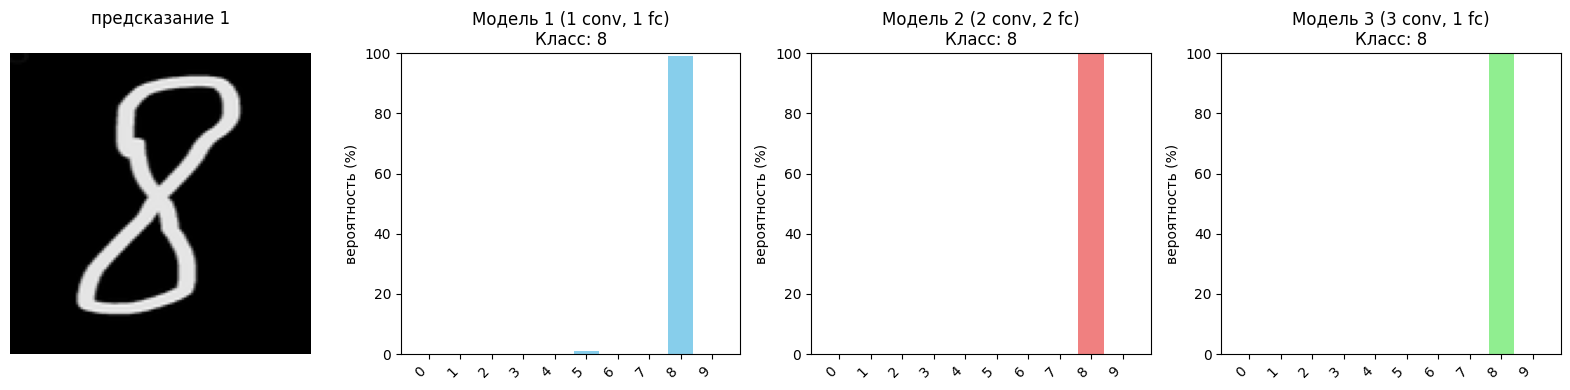


предсказание 2

Модель 1 (1 conv, 1 fc):
  предсказание: 8
  уверенность: 98.92%
  вероятности:
    Класс 0:   0.00%
    Класс 1:   0.09%
    Класс 2:   0.00%
    Класс 3:   0.02%
    Класс 4:   0.00%
    Класс 5:   0.91%
    Класс 6:   0.05%
    Класс 7:   0.00%
    Класс 8:  98.92%
    Класс 9:   0.00%

Модель 2 (2 conv, 2 fc):
  предсказание: 8
  уверенность: 100.00%
  вероятности:
    Класс 0:   0.00%
    Класс 1:   0.00%
    Класс 2:   0.00%
    Класс 3:   0.00%
    Класс 4:   0.00%
    Класс 5:   0.00%
    Класс 6:   0.00%
    Класс 7:   0.00%
    Класс 8: 100.00%
    Класс 9:   0.00%

Модель 3 (3 conv, 1 fc):
  предсказание: 8
  уверенность: 100.00%
  вероятности:
    Класс 0:   0.00%
    Класс 1:   0.00%
    Класс 2:   0.00%
    Класс 3:   0.00%
    Класс 4:   0.00%
    Класс 5:   0.00%
    Класс 6:   0.00%
    Класс 7:   0.00%
    Класс 8: 100.00%
    Класс 9:   0.00%


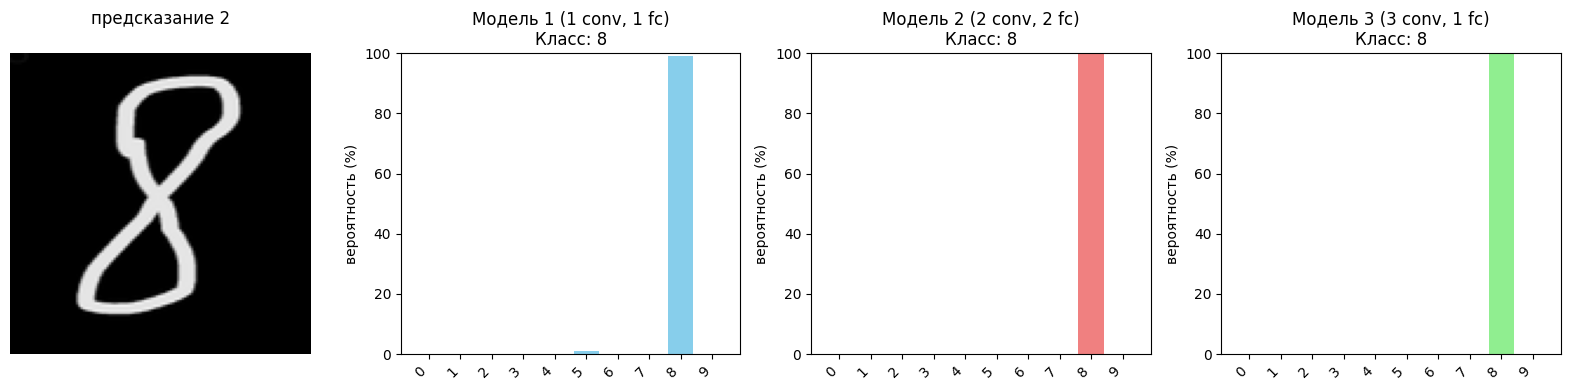


предсказание 3

Модель 1 (1 conv, 1 fc):
  предсказание: 8
  уверенность: 98.92%
  вероятности:
    Класс 0:   0.00%
    Класс 1:   0.09%
    Класс 2:   0.00%
    Класс 3:   0.02%
    Класс 4:   0.00%
    Класс 5:   0.91%
    Класс 6:   0.05%
    Класс 7:   0.00%
    Класс 8:  98.92%
    Класс 9:   0.00%

Модель 2 (2 conv, 2 fc):
  предсказание: 8
  уверенность: 100.00%
  вероятности:
    Класс 0:   0.00%
    Класс 1:   0.00%
    Класс 2:   0.00%
    Класс 3:   0.00%
    Класс 4:   0.00%
    Класс 5:   0.00%
    Класс 6:   0.00%
    Класс 7:   0.00%
    Класс 8: 100.00%
    Класс 9:   0.00%

Модель 3 (3 conv, 1 fc):
  предсказание: 8
  уверенность: 100.00%
  вероятности:
    Класс 0:   0.00%
    Класс 1:   0.00%
    Класс 2:   0.00%
    Класс 3:   0.00%
    Класс 4:   0.00%
    Класс 5:   0.00%
    Класс 6:   0.00%
    Класс 7:   0.00%
    Класс 8: 100.00%
    Класс 9:   0.00%


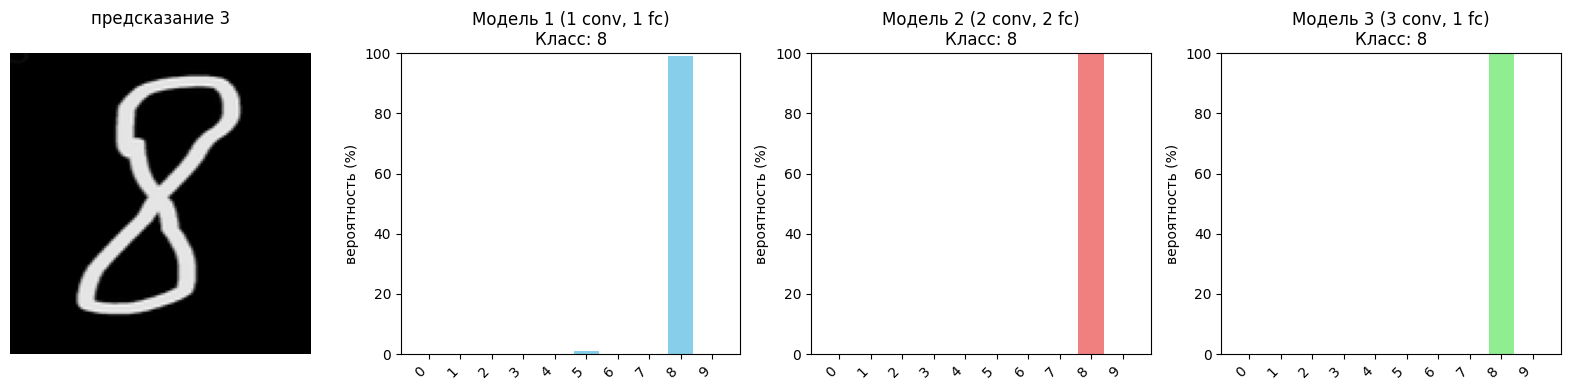

In [77]:
if custom_image is not None:
    # подготовка картинки: в градации серого и размер 28x28 под MNIST
    gray_image = Image.fromarray(custom_image).convert('L').resize((28, 28), Image.Resampling.LANCZOS)
    custom_image_tensor = torch.from_numpy(np.array(gray_image, dtype=np.float32) / 255.0).unsqueeze(0).unsqueeze(0).to(device)
    
    mnist_classes = [str(i) for i in range(10)]  # классы 0-9
    
    # функция
    def predict_and_print(model, image_tensor, model_name, class_labels):
        model.eval()
        with torch.no_grad():
            pred = model(image_tensor)
            prob = torch.nn.functional.softmax(pred, dim=1)
            class_idx = torch.argmax(prob, dim=1).item()
            confidence = prob[0, class_idx].item() * 100
        
        print(f"\n{model_name}:")
        print(f"  предсказание: {class_labels[class_idx]}")
        print(f"  уверенность: {confidence:.2f}%")
        print(f"  вероятности:")
        for i, cls in enumerate(class_labels):
            print(f"    Класс {cls}: {prob[0, i].item() * 100:6.2f}%")
        
        return prob, class_idx
    
    # список моделей и их названий
    models = [model1, model2, model3]
    model_names = ["Модель 1 (1 conv, 1 fc)", "Модель 2 (2 conv, 2 fc)", "Модель 3 (3 conv, 1 fc)"]
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    
    for pred_num in range(3):
        print(f"\n{'='*60}")
        print(f"предсказание {pred_num + 1}")
        print(f"{'='*60}")
        
        predictions = []
        for model_idx, (model, model_name) in enumerate(zip(models, model_names)):
            prob, class_idx = predict_and_print(model, custom_image_tensor, model_name, mnist_classes)
            predictions.append((prob, class_idx, model_name, colors[model_idx]))
        
        plt.figure(figsize=(16, 4))
        
        # показываем картинку (исходная цветная)
        plt.subplot(1, 4, 1)
        plt.imshow(custom_image)
        plt.axis('off')
        plt.title(f'предсказание {pred_num + 1}\n')
        
        # графики вероятностей для каждой модели
        for subplot_idx, (prob, class_idx, model_name, color) in enumerate(predictions):
            plt.subplot(1, 4, subplot_idx + 2)
            plt.bar(range(len(mnist_classes)), prob[0].cpu().numpy() * 100, color=color)
            plt.xticks(range(len(mnist_classes)), mnist_classes, rotation=45, ha='right')
            plt.ylabel('вероятность (%)')
            plt.title(f'{model_name}\nКласс: {mnist_classes[class_idx]}')
            plt.ylim([0, 100])
        
        plt.tight_layout()
        plt.show()
else:
    print("нет картинки")